In [1]:
import dask
import dask_awkward as dak
import mplhep as hep
import numpy as np
from coffea.dataset_tools import preprocess
from distributed import Client
from matplotlib import pyplot as plt

import egamma_tnp
from egamma_tnp import ElectronTagNProbeFromNanoAOD, ElectronTagNProbeFromNTuples
from egamma_tnp.plot import plot_efficiency
from egamma_tnp.utils import convert_nd_mll_hists_to_1d_hists, create_hists_root_file_for_fitter

hep.style.use("CMS")
hep.style.use({"font.size": 16})
hep.style.use({"figure.figsize": (6.4, 4.8)})

egamma_tnp.binning.set(
    "pt_bins",
    [
        5,
        10,
        12,
        14,
        16,
        18,
        20,
        23,
        26,
        28,
        30,
        32,
        34,
        36,
        38,
        40,
        45,
        50,
        60,
        80,
        100,
        150,
        250,
        400,
    ],
)

In [2]:
help(ElectronTagNProbeFromNTuples)

Help on class ElectronTagNProbeFromNTuples in module egamma_tnp.ntuple_efficiency:

class ElectronTagNProbeFromNTuples(egamma_tnp._base_tagnprobe.BaseTagNProbe)
 |  ElectronTagNProbeFromNTuples(fileset, filters, *, tags_pt_cut=35, probes_pt_cut=None, tags_abseta_cut=2.5, probes_abseta_cut=2.5, cutbased_id=None, extra_tags_mask=None, extra_probes_mask=None, goldenjson=None, extra_filter=None, extra_filter_args=None, use_sc_eta=False, use_sc_phi=False, avoid_ecal_transition_tags=True, avoid_ecal_transition_probes=False)
 |  
 |  Method resolution order:
 |      ElectronTagNProbeFromNTuples
 |      egamma_tnp._base_tagnprobe.BaseTagNProbe
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, fileset, filters, *, tags_pt_cut=35, probes_pt_cut=None, tags_abseta_cut=2.5, probes_abseta_cut=2.5, cutbased_id=None, extra_tags_mask=None, extra_probes_mask=None, goldenjson=None, extra_filter=None, extra_filter_args=None, use_sc_eta=False, use_sc_phi=False, avoid_ecal_trans

In [3]:
help(ElectronTagNProbeFromNanoAOD)

Help on class ElectronTagNProbeFromNanoAOD in module egamma_tnp.nanoaod_efficiency:

class ElectronTagNProbeFromNanoAOD(egamma_tnp._base_tagnprobe.BaseTagNProbe)
 |  ElectronTagNProbeFromNanoAOD(fileset, filters, *, is_photon_filter=None, trigger_pt=None, tags_pt_cut=35, probes_pt_cut=None, tags_abseta_cut=2.5, probes_abseta_cut=2.5, filterbit=None, cutbased_id=None, extra_tags_mask=None, extra_probes_mask=None, goldenjson=None, extra_filter=None, extra_filter_args=None, use_sc_eta=False, use_sc_phi=False, avoid_ecal_transition_tags=True, avoid_ecal_transition_probes=False, require_event_to_pass_hlt_filter=True)
 |  
 |  Method resolution order:
 |      ElectronTagNProbeFromNanoAOD
 |      egamma_tnp._base_tagnprobe.BaseTagNProbe
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, fileset, filters, *, is_photon_filter=None, trigger_pt=None, tags_pt_cut=35, probes_pt_cut=None, tags_abseta_cut=2.5, probes_abseta_cut=2.5, filterbit=None, cutbased_id=None, extra_

In [4]:
client = Client(dashboard_address=":12345")

In [13]:
fileset = {"Run2023": {"files": {"../tnpData/Run3_2023_ZMassCut/data/data_EGamma0_crab_2023_Run2023C_0v1.root": "tnpEleTrig/fitter_tree"}}}

print(fileset)

fileset_available, fileset_updated = preprocess(fileset, step_size=500_000, skip_bad_files=True)

{'Run2023': {'files': {'../tnpData/Run3_2023_ZMassCut/data/data_EGamma0_crab_2023_Run2023C_0v1.root': 'tnpEleTrig/fitter_tree'}}}


In [14]:
tnp = ElectronTagNProbeFromNTuples(fileset_available, [""], use_sc_eta=True)

arrays = tnp.get_tnp_arrays(cut_and_count=True, vars=["el_pt", "el_eta"])
histograms = tnp.get_1d_pt_eta_phi_tnp_histograms(
    cut_and_count=True,
    eta_regions_pt={
        "barrel": [0.0, 1.4442],
        "endcap_loweta": [1.566, 2.0],
        "endcap_higheta": [2.0, 2.5],
    },
    plateau_cut=35,
)

arrays, histograms

FieldNotFoundError: no field '' in record with 150 fields

In [7]:
arrays["Run2023"]["passing"].fields

['el_pt', 'el_eta']

In [8]:
histograms["Run2023"]["pt"]["barrel"]["passing"]

Hist(Variable(array([  5.,  10.,  12.,  14.,  16.,  18.,  20.,  23.,  26.,  28.,  30.,
        32.,  34.,  36.,  38.,  40.,  45.,  50.,  60.,  80., 100., 150.,
       250., 400.]), name='pt', label='Pt [GeV]'), storage=Weight()) # Sum: WeightedSum(value=0, variance=0) (has staged fills)

In [9]:
arrays_computed, histograms_computed = dask.compute(arrays, histograms)

In [10]:
arrays_computed

{'Run2023': {'passing': <Array [{el_pt: 39.3, el_eta: ..., ...}, ...] type='11009520 * {el_pt: floa...'>,
  'failing': <Array [{el_pt: 44.3, el_eta: 1.04}, ...] type='6040808 * {el_pt: float32[p...'>}}

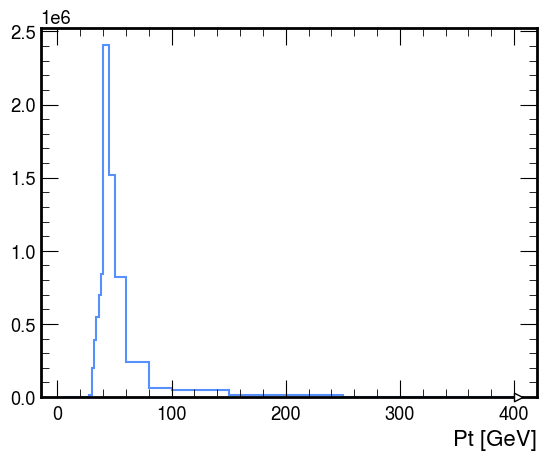

In [11]:
histograms_computed["Run2023"]["pt"]["barrel"]["passing"].plot()
plt.show()

In [12]:
out = dask.compute(tnp.get_nd_tnp_histograms(cut_and_count=True, vars=["el_eta", "el_pt"]))[0]

out

{'Run2023': {'passing': Hist(
    Variable(array([-2.5   , -2.4   , -2.3   , -2.2   , -2.1   , -2.    , -1.9   ,
         -1.8   , -1.7   , -1.566 , -1.4442, -1.3   , -1.2   , -1.1   ,
         -1.    , -0.9   , -0.8   , -0.7   , -0.6   , -0.5   , -0.4   ,
         -0.3   , -0.2   , -0.1   ,  0.    ,  0.1   ,  0.2   ,  0.3   ,
          0.4   ,  0.5   ,  0.6   ,  0.7   ,  0.8   ,  0.9   ,  1.    ,
          1.1   ,  1.2   ,  1.3   ,  1.4442,  1.566 ,  1.7   ,  1.8   ,
          1.9   ,  2.    ,  2.1   ,  2.2   ,  2.3   ,  2.4   ,  2.5   ]), name='el_eta', label='El_eta'),
    Variable(array([  5. ,  10. ,  12.5,  15. ,  17.5,  20. ,  22.5,  25. ,  30. ,
          35. ,  40. ,  45. ,  50. ,  60. ,  80. , 100. , 150. , 200. ,
         250. , 300. , 350. , 400. ]), name='el_pt', label='El_pt'),
    storage=Weight()) # Sum: WeightedSum(value=1.10037e+07, variance=1.10037e+07) (WeightedSum(value=1.10095e+07, variance=1.10095e+07) with flow),
  'failing': Hist(
    Variable(array([-2.5   , -

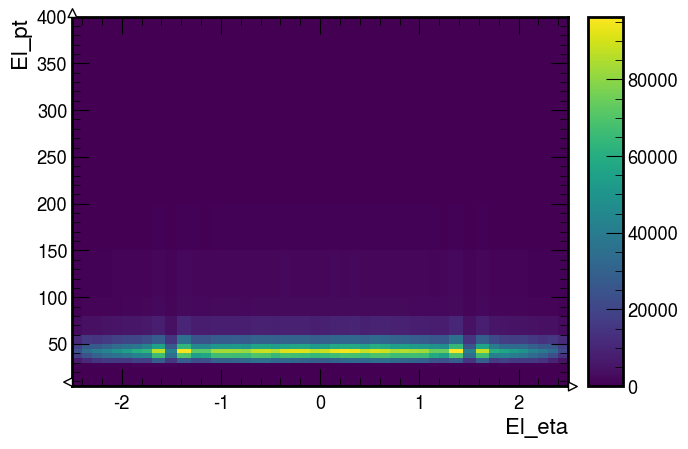

In [13]:
out["Run2023"]["passing"].plot()
plt.show()

In [14]:
histograms_computed["Run2023"]["pt"]["barrel"]["passing"].values(flow=True)

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 9.690000e+02, 1.383700e+04, 1.979860e+05,
       3.930740e+05, 5.449860e+05, 7.000390e+05, 8.449880e+05,
       2.405290e+06, 1.520639e+06, 8.231400e+05, 2.406930e+05,
       6.513800e+04, 4.842400e+04, 1.667200e+04, 2.968000e+03,
       4.420000e+02])

In [15]:
out["Run2023"]["passing"][-1.4442j:1.4442j:sum, :].values(flow=True)

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       1.480600e+04, 8.449860e+05, 1.836087e+06, 2.405290e+06,
       1.520639e+06, 8.231400e+05, 2.406930e+05, 6.513800e+04,
       4.842400e+04, 1.237900e+04, 4.293000e+03, 1.758000e+03,
       8.100000e+02, 4.000000e+02, 4.420000e+02])

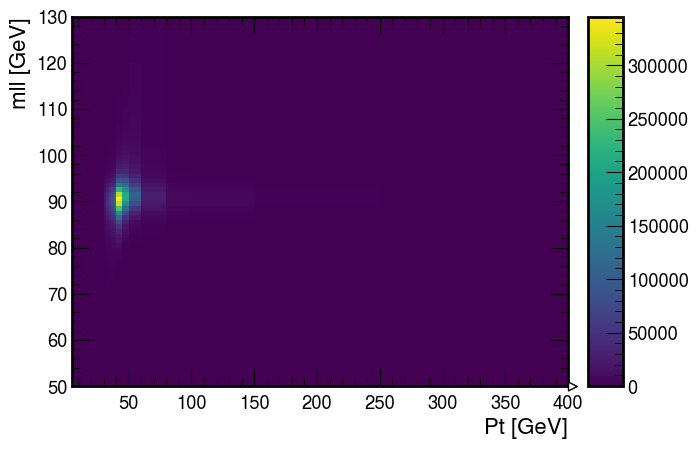

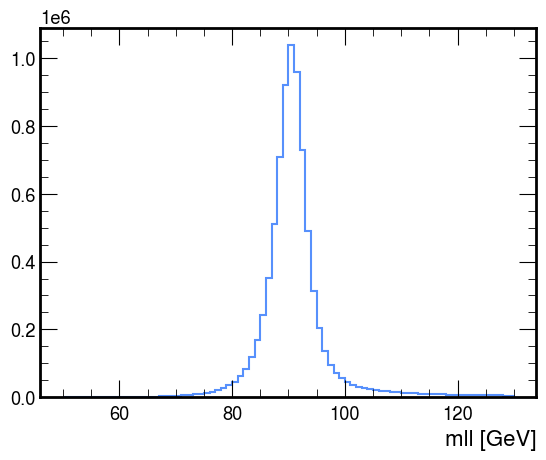

In [16]:
out = dask.compute(
    tnp.get_1d_pt_eta_phi_tnp_histograms(
        cut_and_count=False,
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=35,
    )
)[0]

out["Run2023"]["pt"]["barrel"]["passing"].plot()
plt.show()

out["Run2023"]["pt"]["barrel"]["passing"][sum, :].plot()  # or .project("mll") instead of [sum, :]
plt.show()

hists2d = out

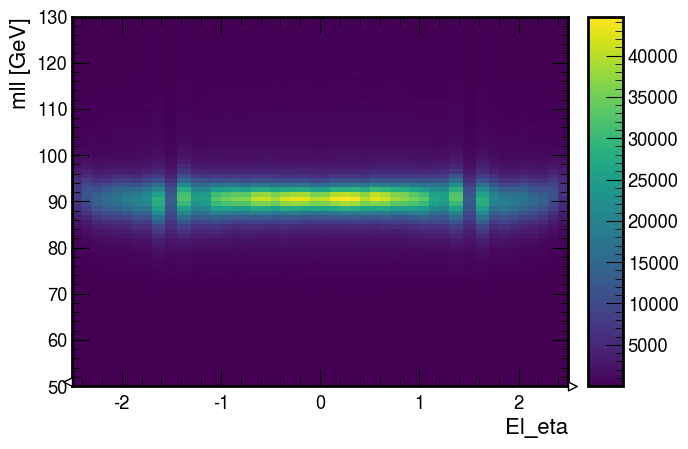

In [17]:
out = dask.compute(tnp.get_nd_tnp_histograms(cut_and_count=False, vars=["el_eta", "el_pt"]))[0]

out["Run2023"]["passing"][:, sum, :].plot()
plt.show()

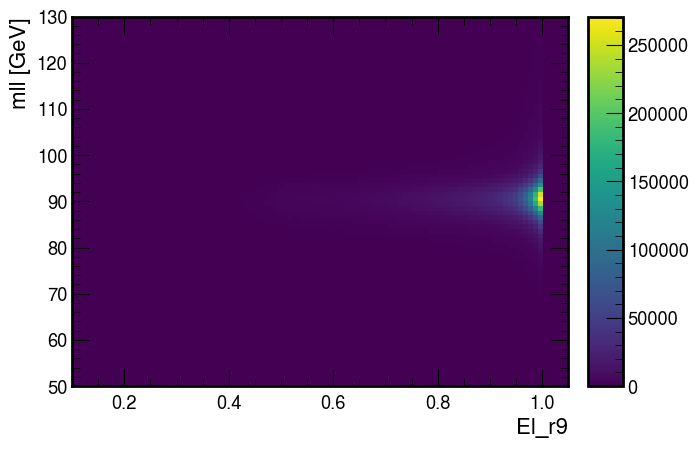

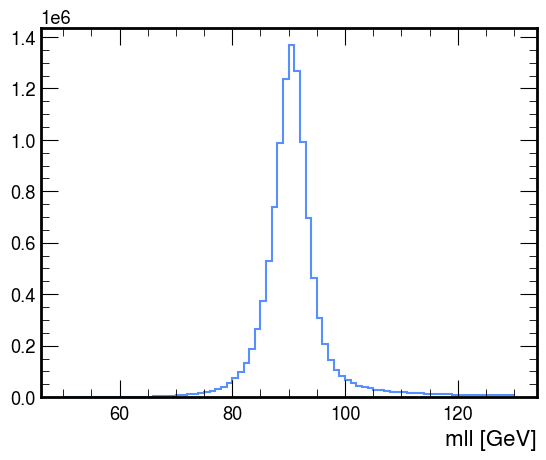

In [18]:
egamma_tnp.binning.set("el_r9_bins", list(np.linspace(0.1, 1.05, 100)))

out = dask.compute(tnp.get_nd_tnp_histograms(cut_and_count=False, vars=["el_eta", "el_r9"]))[0]

out["Run2023"]["passing"][sum, :, :].plot()
plt.show()

out["Run2023"]["passing"].project("mll").plot()
plt.show()

In [19]:
dak.necessary_columns(tnp.get_nd_tnp_histograms(cut_and_count=False, vars=["el_eta", "el_r9"]))

{'from-uproot-784e28a6a1b32bef2239d5a1c4413216': frozenset({'el_eta',
            'el_pt',
            'el_q',
            'el_r9',
            'pair_mass',
            'passHltEle30WPTightGsf',
            'tag_Ele_pt',
            'tag_Ele_q',
            'tag_sc_eta'})}

In [20]:
egamma_tnp.binning.set("el_pt_bins", [10, 20, 35, 50, 100, 200, 500])
egamma_tnp.binning.set("el_sc_eta_bins", [-2.5, -2.0, -1.566, -1.4442, -0.8, 0.0, 0.8, 1.4442, 1.566, 2.0, 2.5])

histsnd = dask.compute(tnp.get_nd_tnp_histograms(cut_and_count=False, vars=["el_sc_eta", "el_pt"]))[0]
histsnd["Run2023"]["passing"][-1.4442j:1.4442j:sum, sum, :]

Hist(Regular(80, 50, 130, name='mll', label='mll [GeV]'), storage=Weight()) # Sum: WeightedSum(value=7.87099e+06, variance=7.87099e+06)

In [21]:
hists, binning = convert_nd_mll_hists_to_1d_hists(histsnd["Run2023"], axes=["el_sc_eta", "el_pt"])

In [22]:
hists["passing"]["el_sc_eta_0p00To0p80_el_pt_35p00To50p00"]

Hist(Regular(80, 50, 130, name='mll', label='mll [GeV]'), storage=Weight()) # Sum: WeightedSum(value=1.71374e+06, variance=1.71374e+06)

In [23]:
histsnd["Run2023"]["passing"][0j:0.8j:sum, 35j:50j:sum, :]

Hist(Regular(80, 50, 130, name='mll', label='mll [GeV]'), storage=Weight()) # Sum: WeightedSum(value=1.71374e+06, variance=1.71374e+06)

In [24]:
create_hists_root_file_for_fitter(histsnd["Run2023"], "hists.root", "binning.pkl", axes=["el_sc_eta", "el_pt"])

In [25]:
import pickle

bins = pickle.load(open("binning.pkl", "rb"))

In [26]:
bins

{'bins': [{'cut': 'el_sc_eta >= -2.500000 && el_sc_eta < -2.000000 && el_pt >= 10.000000 && el_pt < 20.000000',
   'name': 'bin00_el_sc_eta_m2p50Tom2p00_el_pt_10p00To20p00',
   'vars': {'el_sc_eta': {'min': -2.5, 'max': -2.0},
    'el_pt': {'min': 10.0, 'max': 20.0}},
   'title': '; -2.500 < el_sc_eta < -2.000; 10.000 < el_pt < 20.000'},
  {'cut': 'el_sc_eta >= -2.000000 && el_sc_eta < -1.566000 && el_pt >= 10.000000 && el_pt < 20.000000',
   'name': 'bin01_el_sc_eta_m2p00Tom1p57_el_pt_10p00To20p00',
   'vars': {'el_sc_eta': {'min': -2.0, 'max': -1.566},
    'el_pt': {'min': 10.0, 'max': 20.0}},
   'title': '; -2.000 < el_sc_eta < -1.566; 10.000 < el_pt < 20.000'},
  {'cut': 'el_sc_eta >= -1.566000 && el_sc_eta < -1.444200 && el_pt >= 10.000000 && el_pt < 20.000000',
   'name': 'bin02_el_sc_eta_m1p57Tom1p44_el_pt_10p00To20p00',
   'vars': {'el_sc_eta': {'min': -1.566, 'max': -1.4442},
    'el_pt': {'min': 10.0, 'max': 20.0}},
   'title': '; -1.566 < el_sc_eta < -1.444; 10.000 < el_pt <

In [27]:
files = !ls ../tnptuples/*
fileset = {}

for path in files:
    f = path.split("/")[2][:-5]
    fileset[f] = {"files": {path: "tnpEleTrig/fitter_tree"}}

fileset_available, fileset_updated = preprocess(fileset, step_size=500_000, skip_bad_files=True)

In [28]:
hlt_paths = {
    "Ele30": "passHltEle30WPTightGsf",
    "Ele32": "passHltEle32WPTightGsf",
    "Ele115": "passHltEle115CaloIdVTGsfTrkIdTGsf",
    "Ele135": "passHltEle135CaloIdVTGsfTrkIdTGsf",
    "Ele23Ele12Leg1": "passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg1L1match",
    "Ele23Ele12Leg2": "passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg2",
    "DoubleEle33SeededLeg": "passHltDoubleEle33CaloIdLMWSeedLegL1match",
    "DoubleEle33UnseededLeg": "passHltDoubleEle33CaloIdLMWUnsLeg",
}

plateau_cuts = {
    "Ele30": 35,
    "Ele32": 35,
    "Ele115": 120,
    "Ele135": 140,
    "Ele23Ele12Leg1": 25,
    "Ele23Ele12Leg2": 15,
    "DoubleEle33SeededLeg": 35,
    "DoubleEle33UnseededLeg": 35,
}

triggers = {}

for name, path in hlt_paths.items():
    triggers[name] = ElectronTagNProbeFromNTuples(fileset_available, path, cutbased_id="passingCutBasedTight122XV1")

triggers

{'Ele30': ElectronTagNProbeFromNTuples(passHltEle30WPTightGsf, Number of files: 27, Golden JSON: None),
 'Ele32': ElectronTagNProbeFromNTuples(passHltEle32WPTightGsf, Number of files: 27, Golden JSON: None),
 'Ele115': ElectronTagNProbeFromNTuples(passHltEle115CaloIdVTGsfTrkIdTGsf, Number of files: 27, Golden JSON: None),
 'Ele135': ElectronTagNProbeFromNTuples(passHltEle135CaloIdVTGsfTrkIdTGsf, Number of files: 27, Golden JSON: None),
 'Ele23Ele12Leg1': ElectronTagNProbeFromNTuples(passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg1L1match, Number of files: 27, Golden JSON: None),
 'Ele23Ele12Leg2': ElectronTagNProbeFromNTuples(passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg2, Number of files: 27, Golden JSON: None),
 'DoubleEle33SeededLeg': ElectronTagNProbeFromNTuples(passHltDoubleEle33CaloIdLMWSeedLegL1match, Number of files: 27, Golden JSON: None),
 'DoubleEle33UnseededLeg': ElectronTagNProbeFromNTuples(passHltDoubleEle33CaloIdLMWUnsLeg, Number of files: 27, Golden JSON: None)}

In [29]:
%%time

to_compute = {}

for name, trigger in triggers.items():
    if name == "Ele115" or name == "Ele135":
        egamma_tnp.binning.set(
            "pt_bins",
            [
                5,
                10,
                15,
                20,
                22,
                26,
                28,
                30,
                32,
                34,
                36,
                38,
                40,
                45,
                50,
                60,
                80,
                100,
                105,
                110,
                115,
                120,
                125,
                130,
                135,
                140,
                145,
                150,
                200,
                250,
                300,
                350,
                400,
            ],
        )
    else:
        egamma_tnp.binning.set(
            "pt_bins",
            [
                5,
                10,
                12,
                14,
                16,
                18,
                20,
                23,
                26,
                28,
                30,
                32,
                34,
                36,
                38,
                40,
                45,
                50,
                60,
                80,
                100,
                150,
                250,
                400,
            ],
        )
    plateau_cut = plateau_cuts[name]
    to_compute[name] = trigger.get_1d_pt_eta_phi_tnp_histograms(
        uproot_options={"allow_read_errors_with_report": True},
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=plateau_cut,
    )


dak.necessary_columns(to_compute)

2024-05-08 14:13:39,149 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-05-08 14:13:42,752 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-05-08 14:13:46,315 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-05-08 14:13:49,840 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-05-08 14:13:53,243 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-05-08 14:13:56,745 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-05-08 14:14:00,144 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-05-08 14:14:03,562 - distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 2min 35s, sys: 2.55 s, total: 2min 37s
Wall time: 2min 37s


{'from-uproot-38a7b38951949a444dc9c7555a5df6c7': frozenset({'el_eta',
            'el_phi',
            'el_pt',
            'el_q',
            'pair_mass',
            'passHltDoubleEle33CaloIdLMWSeedLegL1match',
            'passHltDoubleEle33CaloIdLMWUnsLeg',
            'passHltEle115CaloIdVTGsfTrkIdTGsf',
            'passHltEle135CaloIdVTGsfTrkIdTGsf',
            'passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg1L1match',
            'passHltEle23Ele12CaloIdLTrackIdLIsoVLLeg2',
            'passHltEle30WPTightGsf',
            'passHltEle32WPTightGsf',
            'passingCutBasedTight122XV1',
            'tag_Ele_eta',
            'tag_Ele_pt',
            'tag_Ele_q'}),
 'from-uproot-2e32e4d64d2f70a4920b99b0a7924541': frozenset({'el_eta',
            'el_phi',
            'el_pt',
            'el_q',
            'pair_mass',
            'passHltDoubleEle33CaloIdLMWSeedLegL1match',
            'passHltDoubleEle33CaloIdLMWUnsLeg',
            'passHltEle115CaloIdVTGsfTrkIdTGsf',
      

In [30]:
%%time

out = dask.compute(to_compute)[0]

2024-05-08 14:15:55,396 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-05-08 14:15:57,326 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-05-08 14:15:58,884 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-05-08 14:16:00,312 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-05-08 14:16:01,668 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-05-08 14:16:02,169 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-05-08 14:16:03,402 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-05-08 14:16:03,900 - distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 2min 55s, sys: 6.53 s, total: 3min 2s
Wall time: 3min 34s


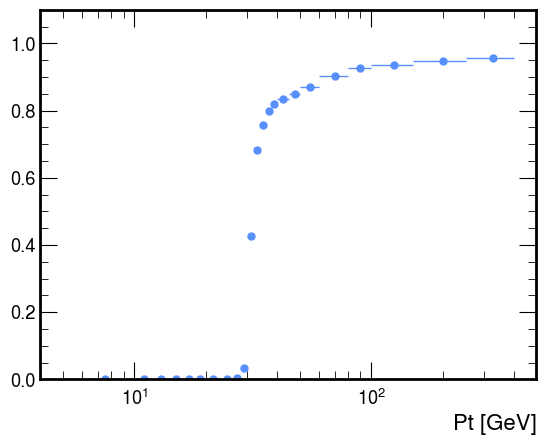

In [31]:
plot_efficiency(
    out["Ele30"][0]["data_EGamma_Run2023"]["pt"]["barrel"]["passing"],
    out["Ele30"][0]["data_EGamma_Run2023"]["pt"]["barrel"]["failing"],
)

plt.xscale("log")
plt.ylim(0, 1.1)
plt.show()